In [1]:
pip install pandas numpy scikit-learn torch

  Using cached torch-2.8.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.8/241.3 MB 2.6 MB/s eta 0:01:32
   ---------------------------------------- 1.3/241.3 MB 2.5 MB/s eta 0:01:36
   ---------------------------------------- 1.3/241.3 MB 2.5 MB/s eta 0:01:36
   ---------------------------------------- 1.3/241.3 MB 2.5 MB/s eta 0:01:36
   ---------------------------------------- 1.3/241.3 MB 2.5 MB/s eta 0:01:36
   ---------------------------------------- 2.1/241.3 MB 1.5 MB/s eta 0:02:40
   ---------------------------------------- 2.4/241.3 MB 1.6 MB/s eta 0:02:31
   ---------------------------------------- 2.4/241.3 MB 1.6 MB/s eta 0:02:31
   ---------------------------------------- 2.4/241.3 MB 1.6 MB/s eta 0:02:31
   ------------

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [4]:
df=pd.read_csv("income.csv")

In [5]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [67]:
cat_cols=['sex','education','education-num','marital-status','workclass']

In [68]:
con_cols=['age','hours-per-week']

In [69]:
label=['label']

In [83]:
print(f'{len(cat_cols)} columns')
print(f'{len(con_cols)} columns')
print(f'{len(label)} columns')

5 columns
2 columns
1 columns


In [70]:
for col in cat_cols:
    df[col]=df[col].astype('category')

In [71]:
cat_szs=[len(df[col].cat.categories) for col in cat_cols]
emb_szs=[(size,min(50,(size+1)//2)) for size in cat_szs]
print(emb_szs)

[(2, 1), (14, 7), (14, 7), (6, 3), (5, 3)]


In [72]:
cats=np.stack([df[col].cat.codes.values for col in cat_cols],1)
cats[:5]

array([[ 1, 10,  6,  3,  2],
       [ 1, 11, 11,  1,  1],
       [ 1, 10,  6,  0,  3],
       [ 0, 12, 12,  3,  0],
       [ 0,  1,  4,  5,  2]], dtype=int8)

In [73]:
cats_t= torch.tensor(cats,dtype=torch.int64)

In [74]:
cons=np.stack([df[col].values for col in con_cols],1)
cons[:5]

array([[27, 40],
       [47, 50],
       [59, 20],
       [38, 57],
       [64, 40]])

In [75]:
cons_t= torch.tensor(cons,dtype=torch.float32)

In [76]:
y= torch.tensor(df['label'].values,dtype=torch.long)

In [77]:
b=30000
t=5000
cats_train,cat_test=cats_t[:b],cats_t[b:]
con_train,con_test=cons_t[:b],cons_t[b:]
y_train,y_test=y[:b],y[:b]

In [78]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [79]:
model=TabularModel(emb_szs,n_cont=2,out_sz=2,layers=[50],p=0.4)
print(model)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1-2): 2 x Embedding(14, 7)
    (3): Embedding(6, 3)
    (4): Embedding(5, 3)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [80]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [81]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cats_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

epoch:   1  loss: 0.90903246
epoch:  26  loss: 0.60326326
epoch:  51  loss: 0.52297431
epoch:  76  loss: 0.47858816
epoch: 101  loss: 0.44940200
epoch: 126  loss: 0.42146865
epoch: 151  loss: 0.40068004
epoch: 176  loss: 0.38365594
epoch: 201  loss: 0.36722159
epoch: 226  loss: 0.35733917
epoch: 251  loss: 0.34913218
epoch: 276  loss: 0.34110889
epoch: 300  loss: 0.33821985

Duration: 21 seconds


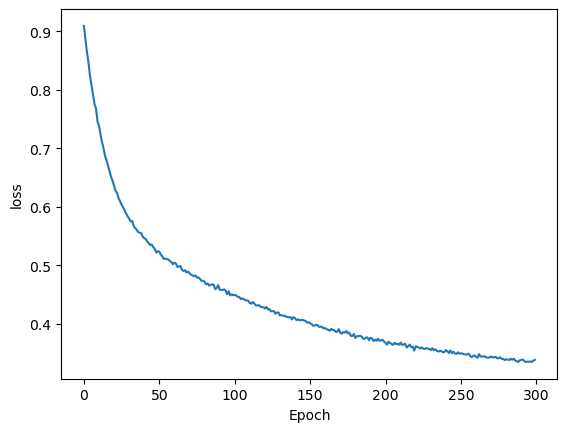

In [88]:
import matplotlib.pyplot as plt
losses_np=[loss.detach().cpu().numpy() for loss in losses]
plt.plot(losses_np)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

In [97]:
cat_test = cats_t[25000:]     
con_test = cons_t[25000:]    
y_test = y[25000:]            


In [98]:
with torch.no_grad():
    y_pred_t = model(cat_test, con_test)     
    loss = criterion(y_pred_t, y_test)        
print(f'Test CE loss: {loss.item():.8f}')

Test CE loss: 0.28691220


In [100]:
y_pred_l=torch.argmax(y_pred_t,dim=1)
correct=(y_pred_l==y_test).sum().item()
accuracy=correct/y_test.size(0)*100
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 87.02%
